In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold 
from sklearn.model_selection import LeaveOneGroupOut 
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from spatialkfold.blocks import spatial_blocks 
from spatialkfold.datasets import load_ames
from spatialkfold.clusters import spatial_kfold_clusters 
from spatialkfold.plotting import spatial_kfold_plot
from spatialkfold.stats import spatial_kfold_stats

# I. Spatial Resampling

In [2]:
ames = load_ames()

In [3]:
ames.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [4]:
ames

,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,...,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Sale_Price,geometry
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141.0,31770,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Pool,No_Fence,None,0,5,2010,WD,Normal,215000,POINT (-93.61975 42.05403)
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80.0,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,No_Pool,Minimum_Privacy,None,0,6,2010,WD,Normal,105000,POINT (-93.61976 42.05301)
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81.0,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Pool,No_Fence,Gar2,12500,6,2010,WD,Normal,172000,POINT (-93.61939 42.05266)
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93.0,11160,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,No_Pool,No_Fence,None,0,4,2010,WD,Normal,244000,POINT (-93.61732 42.05125)
4,Two_Story_1946_and_Newer,Residential_Low_Density,74.0,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,No_Pool,Minimum_Privacy,None,0,3,2010,WD,Normal,189900,POINT (-93.63893 42.06090)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,Split_or_Multilevel,Residential_Low_Density,37.0,7937,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,CulDSac,...,No_Pool,Good_Privacy,None,0,3,2006,WD,Normal,142500,POINT (-93.60478 41.98896)
2926,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,0.0,8885,Pave,No_Alley_Access,Slightly_Irregular,Low,AllPub,Inside,...,No_Pool,Minimum_Privacy,None,0,6,2006,WD,Normal,131000,POINT (-93.60268 41.98831)
2927,Split_Foyer,Residential_Low_Density,62.0,10441,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,No_Pool,Minimum_Privacy,Shed,700,7,2006,WD,Normal,132000,POINT (-93.60685 41.98651)
2928,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,77.0,10010,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,No_Pool,No_Fence,None,0,4,2006,WD,Normal,170000,POINT (-93.60019 41.99092)


In [5]:
# Reproject to the approriate coordinate reference system 

In [6]:
ames_prj = ames.copy().to_crs(ames.estimate_utm_crs())

In [7]:
ames_prj.crs

<Derived Projected CRS: EPSG:32615>
Name: WGS 84 / UTM zone 15N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 96°W and 90°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Manitoba; Nunavut; Ontario. Ecuador -Galapagos. Guatemala. Mexico. United States (USA).
- bounds: (-96.0, 0.0, -90.0, 84.0)
Coordinate Operation:
- name: UTM zone 15N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
# Add an id column for each data point 

In [9]:
ames_prj['id'] = range(len(ames_prj))

### 1. Spatial cluster resampling 

Two clustering algorithms are supported:

- [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) (By default)
- [BisectingKMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.BisectingKMeans.html)

#### 1.1 Using KMeans 

In [ ]:
ames_clusters = spatial_kfold_clusters(gdf=ames_prj, name='id', nfolds= 10, algorithm='kmeans', random_state =569) 

In [11]:
ames_clusters

,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,...,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Sale_Price,geometry,id,folds
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141.0,31770,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,None,0,5,2010,WD,Normal,215000,POINT (448716.789 4655961.485),0,7
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80.0,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,None,0,6,2010,WD,Normal,105000,POINT (448715.802 4655848.124),1,7
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81.0,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,Gar2,12500,6,2010,WD,Normal,172000,POINT (448746.026 4655808.487),2,7
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93.0,11160,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,None,0,4,2010,WD,Normal,244000,POINT (448915.962 4655650.253),3,7
4,Two_Story_1946_and_Newer,Residential_Low_Density,74.0,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,None,0,3,2010,WD,Normal,189900,POINT (447135.458 4656735.276),4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,Split_or_Multilevel,Residential_Low_Density,37.0,7937,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,CulDSac,...,None,0,3,2006,WD,Normal,142500,POINT (449905.137 4648727.785),2925,4
2926,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,0.0,8885,Pave,No_Alley_Access,Slightly_Irregular,Low,AllPub,Inside,...,None,0,6,2006,WD,Normal,131000,POINT (450078.246 4648654.392),2926,4
2927,Split_Foyer,Residential_Low_Density,62.0,10441,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,Shed,700,7,2006,WD,Normal,132000,POINT (449731.661 4648456.532),2927,4
2928,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,77.0,10010,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,None,0,4,2006,WD,Normal,170000,POINT (450286.530 4648942.397),2928,4


In [12]:
# Get the 'tab20' colormap
cols_tab = cm.get_cmap('tab20', 10)
# Generate a list of colors from the colormap
cols = [cols_tab(i) for i in range(10)]
# create a color ramp
color_ramp = ListedColormap(cols)

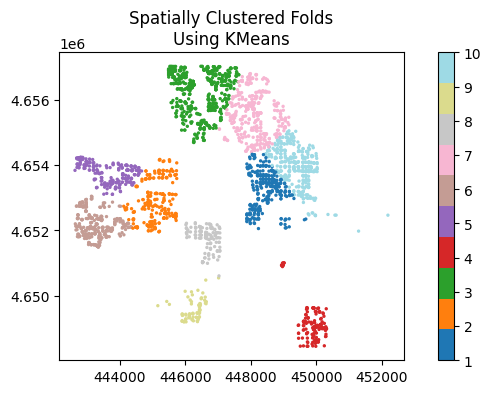

In [ ]:
fig, ax = plt.subplots(1,1 , figsize=(9, 4)) 
ames_clusters.plot(column='folds', ax=ax, cmap=color_ramp, markersize=2, legend=True)
ax.set_title('Spatially Clustered Folds\nUsing KMeans')
plt.show()

In [14]:
# check the number of train and test of the dependent variable for each fold

In [ ]:
ames_clusters_stats = spatial_kfold_stats(X=ames_clusters, y=ames_clusters.Sale_Price, groups=ames_clusters.folds)

In [16]:
ames_clusters_stats

,split,train,test
0,1,2594,336
1,2,2687,243
2,3,2270,660
3,4,2769,161
4,5,2694,236
5,6,2606,324
6,7,2537,393
7,8,2790,140
8,9,2857,73
9,10,2566,364


#### 1.2 Using BisectingKMeans 

In [ ]:
ames_clusters_Biskmeans = spatial_kfold_clusters(gdf=ames_prj, name='id', nfolds=10, algorithm='bisectingkmeans',random_state =569) 

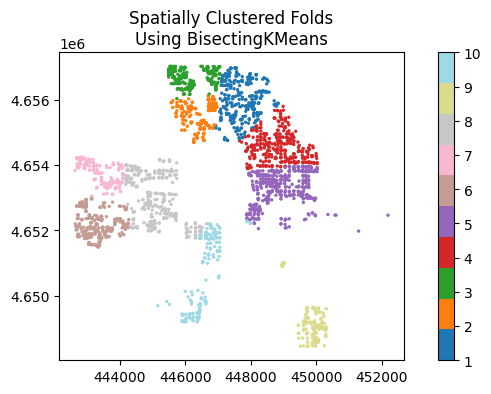

In [ ]:
fig, ax = plt.subplots(1,1 , figsize=(9, 4)) 
ames_clusters_Biskmeans.plot(column='folds', ax=ax, cmap=color_ramp, markersize=2, legend=True)
ax.set_title('Spatially Clustered Folds\nUsing BisectingKMeans')
plt.show()

In [ ]:
ames_clusters_stats_ = spatial_kfold_stats(X=ames_clusters_Biskmeans, y=ames_clusters_Biskmeans.Sale_Price, groups=ames_clusters_Biskmeans.folds)

In [20]:
ames_clusters_stats_

,split,train,test
0,1,2561,369
1,2,2678,252
2,3,2633,297
3,4,2572,358
4,5,2457,473
5,6,2605,325
6,7,2759,171
7,8,2579,351
8,9,2769,161
9,10,2757,173


### 2. Spatial Blocks

#### 2.1 Spatial resampled random blocks

In [ ]:
# create 10 random blocks 
ames_rnd_blocks = spatial_blocks(gdf=ames_prj, width=1500, height=1500, 
                                 method='random', nfolds=10, 
                                 random_state=135)

Text(0.5, 1.0, 'Random Blocks Folds')

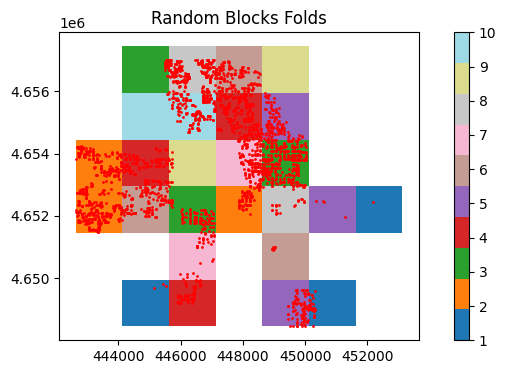

In [ ]:
fig, ax = plt.subplots(1,1 , figsize=(9, 4)) 

ames_rnd_blocks.plot(column='folds', cmap=color_ramp, ax=ax ,lw=0.7, legend=True)
ames_prj.plot(ax=ax, markersize=1, color='r')
ax.set_title('Random Blocks Folds')

In [ ]:
# resample the ames data with the prepared blocks 
ames_res_rnd_blk = gpd.overlay(ames_prj, ames_rnd_blocks)

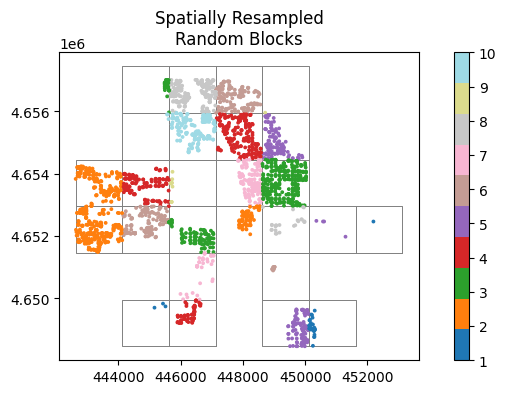

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 4)) 

ames_rnd_blocks.plot(facecolor="none", edgecolor='grey', ax=ax, lw=0.7)
ames_res_rnd_blk.plot(column='folds', cmap=color_ramp, legend=True, ax=ax, markersize=3)
ax.set_title('Spatially Resampled\nRandom Blocks')
plt.show()

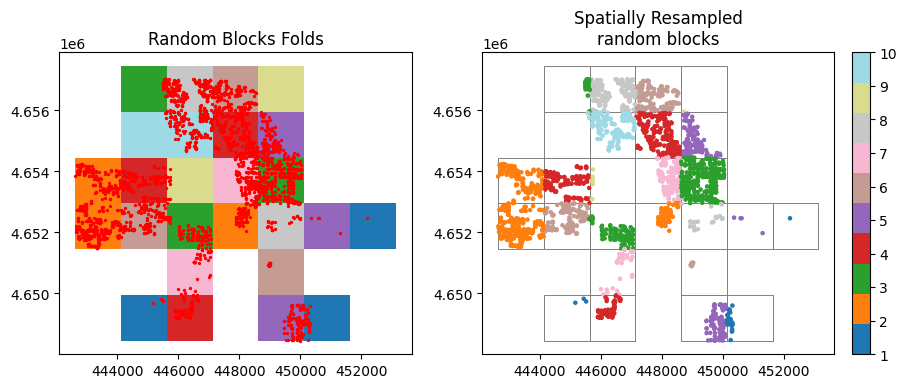

In [ ]:
fig, ax = plt.subplots(1,2 , figsize=(10, 6)) 

# plot 1
ames_rnd_blocks.plot(column='folds', cmap=color_ramp, ax=ax[0] , lw=0.7, legend=False)
ames_prj.plot(ax=ax[0], markersize=2, color='r')
ax[0].set_title('Random Blocks Folds')

# plot 2
ames_rnd_blocks.plot(facecolor="none", edgecolor='grey', ax=ax[1], lw=0.7, legend=False)
ames_res_rnd_blk.plot(column='folds', cmap=color_ramp, legend=False, ax=ax[1], markersize = 2)
ax[1].set_title('Spatially Resampled\nrandom blocks')


im1 = ax[1].scatter(ames_res_rnd_blk.geometry.x , ames_res_rnd_blk.geometry.y, c=ames_res_rnd_blk['folds'],
                 cmap=color_ramp, s=5)

axins1 = inset_axes(
    ax[1],
    width="5%",  # width: 5% of parent_bbox width
    height="50%",  # height: 50%
    loc="lower left",
    bbox_to_anchor=(1.05, 0, 1, 2),
    bbox_transform=ax[1].transAxes,
    borderpad=0
)
fig.colorbar(im1, cax=axins1, ticks= range(1,11))


plt.show()

In [ ]:
ames_res_rnd_blk_stats = spatial_kfold_stats(X=ames_res_rnd_blk, y=ames_res_rnd_blk.Sale_Price, groups=ames_res_rnd_blk.folds)

In [27]:
ames_res_rnd_blk_stats

,split,train,test
0,1,2893,37
1,2,2371,559
2,3,2414,516
3,4,2472,458
4,5,2687,243
5,6,2608,322
6,7,2720,210
7,8,2589,341
8,9,2920,10
9,10,2696,234


#### 2.2 Continuous spatial resampled blocks 

Two option are availble with orientation :
 - 'tb-lr' : top-bottom, left-right
 - ''bt-rl' : bottom-top, right-left

#####  2.2.1. 'tb-lr' : top-bottom, left-right

In [ ]:
ames_cont_blocks = spatial_blocks(gdf=ames_prj, width=1500, height=1500, 
                                  method='continuous', orientation='tb-lr',
                                  nfolds=10, random_state=135)

Text(0.5, 1.0, 'Continuous Blocks Folds\norientation:"tb-lr"')

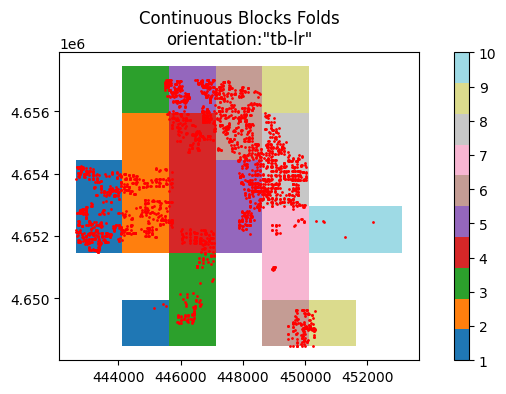

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 4)) 

ames_cont_blocks.plot(column='folds', cmap=color_ramp, ax=ax , lw=0.7, legend=True)
ames_prj.plot(ax=ax, markersize=1, color='r')
ax.set_title('Continuous Blocks Folds\norientation:"tb-lr"')

In [ ]:
# resample the ames data with the prepared blocks 
ames_res_cont_blk = gpd.overlay(ames_prj, ames_cont_blocks)

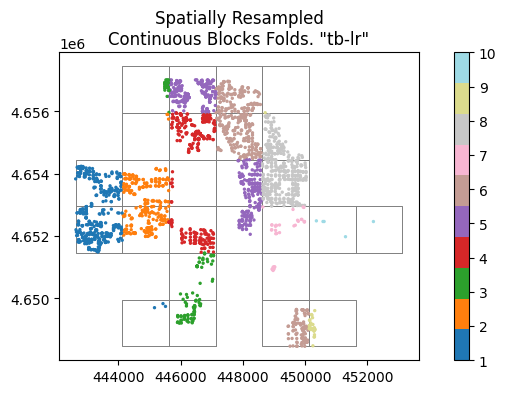

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 4)) 

ames_cont_blocks.plot(facecolor="none", edgecolor='grey', ax=ax ,lw=0.7)
ames_res_cont_blk.plot(column='folds', cmap=color_ramp, legend=True, ax=ax, markersize=2)
ax.set_title('Spatially Resampled\nContinuous Blocks Folds. "tb-lr"')
plt.show()

In [ ]:
ames_res_cont_blk_stats = spatial_kfold_stats(X=ames_res_cont_blk, y=ames_res_cont_blk.Sale_Price, groups=ames_res_cont_blk.folds)

In [33]:
ames_res_cont_blk_stats

,split,train,test
0,1,2446,484
1,2,2628,302
2,3,2801,129
3,4,2567,363
4,5,2367,563
5,6,2402,528
6,7,2894,36
7,8,2444,486
8,9,2896,34
9,10,2925,5


#####  2.2.2. 'bt-rl' : bottom-top, right-left

In [ ]:
ames_cont_blocks_rev = spatial_blocks(gdf=ames_prj, width=1500, height=1500, 
                                      method='continuous', orientation='bt-rl',
                                      nfolds=10, random_state=135)

Text(0.5, 1.0, 'Continuous Blocks Folds\norientation:"bt-rl"')

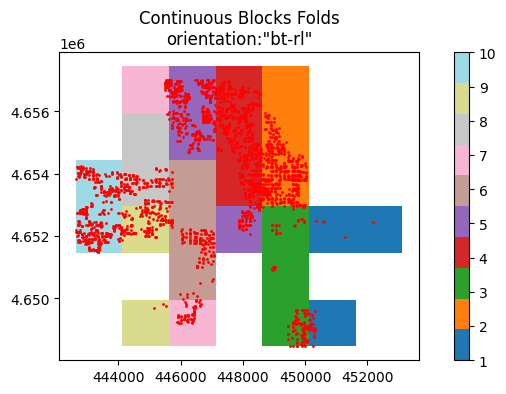

In [ ]:
fig, ax = plt.subplots(1, 1 , figsize=(9, 4)) 

ames_cont_blocks_rev.plot(column='folds',cmap=color_ramp, ax=ax , lw=0.7, legend=True)
ames_prj.plot(ax=ax, markersize=1, color='r')
ax.set_title('Continuous Blocks Folds\norientation:"bt-rl"')

In [ ]:
# resample the ames data with the prepared blocks 
ames_res_cont_blk_rev = gpd.overlay(ames_prj, ames_cont_blocks_rev)

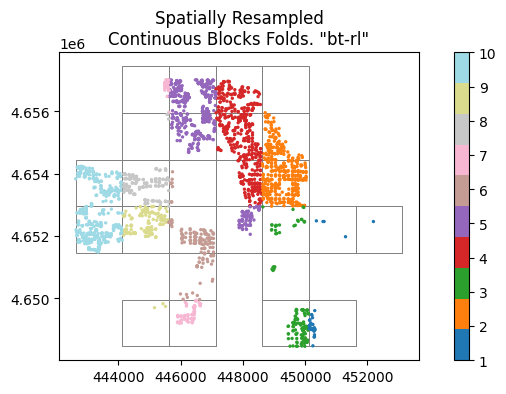

In [ ]:
fig, ax = plt.subplots(1, 1 , figsize=(9, 4)) 

ames_cont_blocks_rev.plot(facecolor="none", edgecolor='grey', ax=ax, lw=0.7)
ames_res_cont_blk_rev.plot(column='folds', cmap=color_ramp, legend=True, ax=ax, markersize=2)
ax.set_title('Spatially Resampled\nContinuous Blocks Folds. "bt-rl"')
plt.show()

In [ ]:
ames_res_cont_blk_rev_stats = spatial_kfold_stats(X=ames_res_cont_blk_rev, y=ames_res_cont_blk_rev.Sale_Price, groups=ames_res_cont_blk_rev.folds)

In [39]:
ames_res_cont_blk_rev_stats

,split,train,test
0,1,2892,38
1,2,2443,487
2,3,2776,154
3,4,2350,580
4,5,2306,624
5,6,2758,172
6,7,2841,89
7,8,2772,158
8,9,2783,147
9,10,2449,481


### 3. Plotting function 

Plot the partitioning of the data at each fold

In [40]:
# check the folds number 
np.unique(ames_clusters.folds.values)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int32)

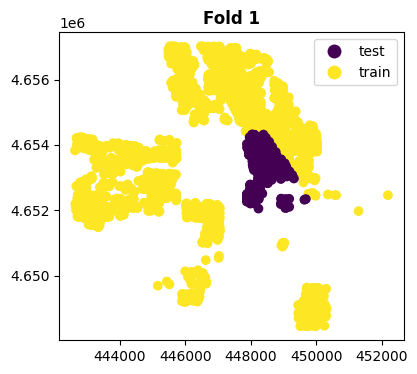

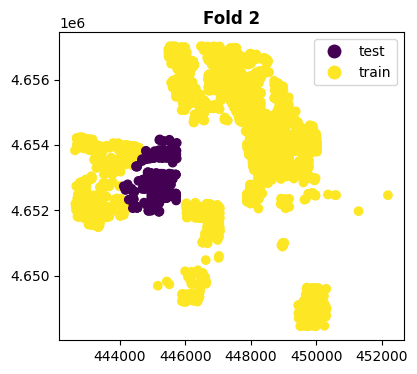

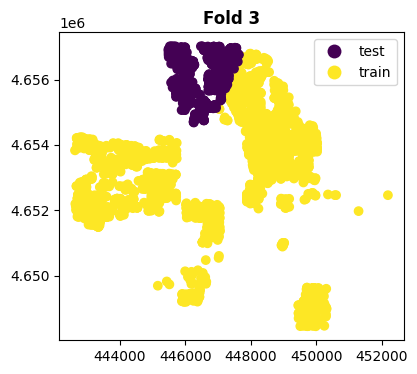

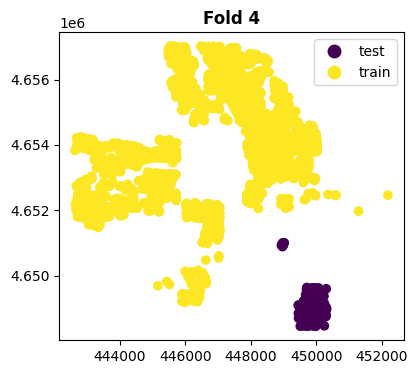

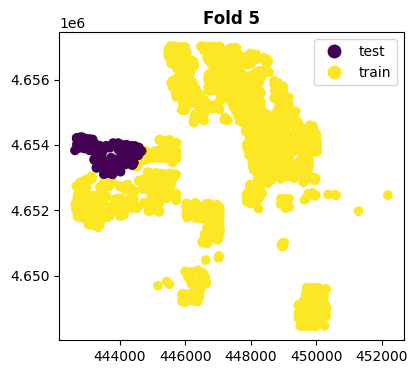

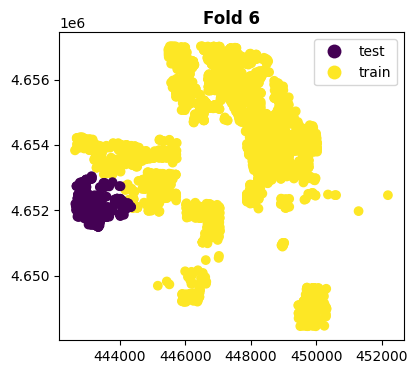

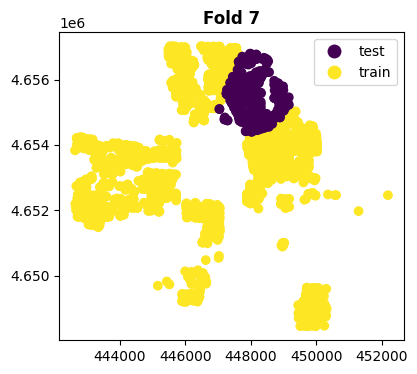

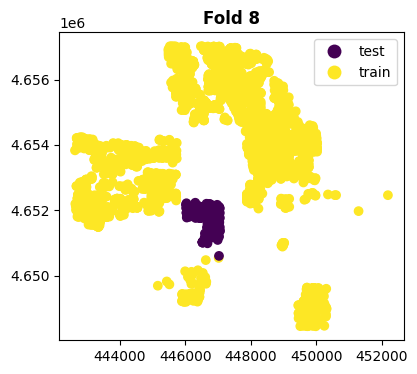

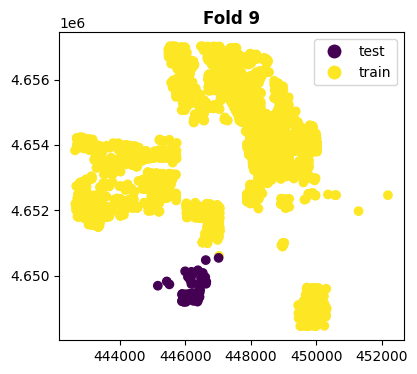

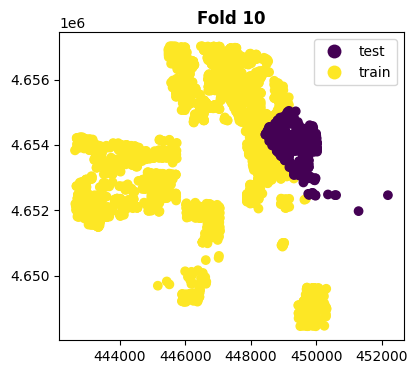

In [ ]:
for i in range(1,11):
    fig, ax = plt.subplots(1, 1 ,figsize=(9, 4))

    spatial_kfold_plot(X=ames_clusters, 
                       geometry=ames_clusters.geometry, 
                       groups=ames_clusters.folds, 
                       fold_num=i, cmap='viridis', ax=ax)

## II. Comparaison : Random VS Spatial Cross validataion

In [42]:
x = ames_prj[['Year_Built', 'Bldg_Type', 'Gr_Liv_Area']]
y = ames_prj[['Sale_Price']]

le = preprocessing.LabelEncoder()
le.fit(x["Bldg_Type"])

list(le.classes_)

le.transform(ames_prj["Bldg_Type"])

array([1, 1, 1, ..., 1, 1, 1])

In [43]:
# Create a copy of the DataFrame and transform the 'Bldg_Type' column to float values
x_copy = x.copy()
x_copy['type'] = le.transform(x_copy["Bldg_Type"])

In [44]:
# Get the independent variables and the dependent variable
X = x_copy[['Year_Built', 'type', 'Gr_Liv_Area']]
y = ames_prj[['Sale_Price']]

In [45]:
X

,Year_Built,type,Gr_Liv_Area
0,1960,1,1656
1,1961,1,896
2,1958,1,1329
3,1968,1,2110
4,1997,1,1629
...,...,...,...
2925,1984,1,1003
2926,1983,1,902
2927,1992,1,970
2928,1974,1,1389


In [46]:
y

,Sale_Price
0,215000
1,105000
2,172000
3,244000
4,189900
...,...
2925,142500
2926,131000
2927,132000
2928,170000


#### 1. Random CV

In [47]:
# Initiate a linear regressor 
reg = LinearRegression()

# Initiate a random CV
kf = KFold(n_splits = 10, shuffle=True, random_state=123)

# evaluate the model and collect the results
random_n_scores = cross_validate(reg, X, y.values.ravel(), 
                                scoring= ['neg_root_mean_squared_error', 'r2', 'neg_mean_absolute_error'], 
                                cv=kf, n_jobs=-1, error_score='raise')

In [48]:
random_n_scores

{'fit_time': array([0.04875755, 0.00484705, 0.0294528 , 0.00492167, 0.02779722,
        0.00347185, 0.00353432, 0.00366235, 0.00342631, 0.00355411]),
 'score_time': array([0.00333762, 0.00328422, 0.00192595, 0.00210905, 0.00261784,
        0.00256896, 0.00241399, 0.00243282, 0.00236797, 0.00263786]),
 'test_neg_root_mean_squared_error': array([-44622.40838673, -39772.65742074, -44832.52140754, -45450.03692245,
        -50212.56009308, -49287.98884697, -39787.31970143, -52631.12777371,
        -58187.6988452 , -38817.22221497]),
 'test_r2': array([0.68186786, 0.65778112, 0.71220595, 0.68753325, 0.62837042,
        0.6002097 , 0.69541257, 0.59591238, 0.61584596, 0.71330735]),
 'test_neg_mean_absolute_error': array([-30212.75246135, -28792.38398508, -31229.5572116 , -32461.80017946,
        -32897.03779732, -32580.57849056, -29550.97789663, -35188.52372995,
        -35547.25333851, -28150.39632891])}

In [49]:
rn_cv_r2 = np.mean(random_n_scores["test_r2"])
rn_cv_rmse = np.mean(abs(random_n_scores["test_neg_root_mean_squared_error"]))
rn_cv_mae = np.mean(abs(random_n_scores["test_neg_mean_absolute_error"]))

print('R2 :',rn_cv_r2)
print('RMSE :',rn_cv_rmse)
print('MAE :',rn_cv_mae)

R2 : 0.6588446547591043
RMSE : 46360.15416128094
MAE : 31661.12614193703


#### Spatial CV:

Using a Leave Region Out Cross vlidation 

In [50]:
# Initiate a leave group out cross valiadtion
group_cvs =  LeaveOneGroupOut()

# Evaluate the model and collect the results
spatial_cluster_scores = cross_validate(reg, X, y.values.ravel(), 
                                scoring= ['neg_root_mean_squared_error', 'r2', 'neg_mean_absolute_error'], 
                                cv= group_cvs.split(X, y, ames_clusters.folds.values.ravel()), # spatial cross validation
                                n_jobs=-1, error_score='raise')

In [51]:
spatial_cluster_scores

{'fit_time': array([0.00429749, 0.00492716, 0.00396943, 0.00706911, 0.00316358,
        0.00376081, 0.02943611, 0.00470543, 0.00425935, 0.00360084]),
 'score_time': array([0.00254512, 0.00494123, 0.00362015, 0.00263953, 0.02695322,
        0.02774906, 0.00390124, 0.00280643, 0.00174475, 0.00153184]),
 'test_neg_root_mean_squared_error': array([-32584.4053578 , -42462.36798639, -69407.94633799, -45746.18536977,
        -36288.31271365, -53574.0001557 , -47398.51917363, -45273.9069811 ,
        -58390.82718082, -30799.97881478]),
 'test_r2': array([0.11236541, 0.48113758, 0.38725729, 0.42016374, 0.39517381,
        0.08606133, 0.64465365, 0.3585445 , 0.28560365, 0.43457762]),
 'test_neg_mean_absolute_error': array([-25492.58263524, -31696.8542513 , -46437.31112439, -33609.13258888,
        -27085.76797277, -29348.50486361, -30496.57294528, -36918.25721939,
        -44205.00840178, -22415.83713075])}

In [52]:
sp_cv_r2 = np.mean(spatial_cluster_scores["test_r2"])
sp_cv_rmse = np.mean(abs(spatial_cluster_scores["test_neg_root_mean_squared_error"]))
sp_cv_mae = np.mean(abs(spatial_cluster_scores["test_neg_mean_absolute_error"]))

print('R2 :',sp_cv_r2)
print('RMSE :',sp_cv_rmse)
print('MAE :',sp_cv_mae)

R2 : 0.3605538569696984
RMSE : 46192.645007163155
MAE : 32770.58291333944


In [53]:
random_n_scores['test_r2']

array([0.68186786, 0.65778112, 0.71220595, 0.68753325, 0.62837042,
       0.6002097 , 0.69541257, 0.59591238, 0.61584596, 0.71330735])

In [54]:
df_rn_cv_scores = pd.DataFrame({'r2': random_n_scores['test_r2'], 
             'rmse' :abs(random_n_scores['test_neg_root_mean_squared_error']),
             'mae' : abs(random_n_scores["test_neg_mean_absolute_error"]),
            'cv_type' : 'Random CV'})

In [55]:
df_rn_cv_scores

,r2,rmse,mae,cv_type
0,0.681868,44622.408387,30212.752461,Random CV
1,0.657781,39772.657421,28792.383985,Random CV
2,0.712206,44832.521408,31229.557212,Random CV
3,0.687533,45450.036922,32461.800179,Random CV
4,0.628370,50212.560093,32897.037797,Random CV
5,0.600210,49287.988847,32580.578491,Random CV
6,0.695413,39787.319701,29550.977897,Random CV
7,0.595912,52631.127774,35188.523730,Random CV
8,0.615846,58187.698845,35547.253339,Random CV
9,0.713307,38817.222215,28150.396329,Random CV


In [56]:
df_sp_cv_scores = pd.DataFrame({'r2': spatial_cluster_scores['test_r2'], 
             'rmse' :abs(spatial_cluster_scores['test_neg_root_mean_squared_error']),
             'mae' : abs(spatial_cluster_scores["test_neg_mean_absolute_error"]),
            'cv_type' : 'Spatial CV'})

In [57]:
df_sp_cv_scores

,r2,rmse,mae,cv_type
0,0.112365,32584.405358,25492.582635,Spatial CV
1,0.481138,42462.367986,31696.854251,Spatial CV
2,0.387257,69407.946338,46437.311124,Spatial CV
3,0.420164,45746.185370,33609.132589,Spatial CV
4,0.395174,36288.312714,27085.767973,Spatial CV
5,0.086061,53574.000156,29348.504864,Spatial CV
6,0.644654,47398.519174,30496.572945,Spatial CV
7,0.358544,45273.906981,36918.257219,Spatial CV
8,0.285604,58390.827181,44205.008402,Spatial CV
9,0.434578,30799.978815,22415.837131,Spatial CV


In [58]:
cv_metrics = pd.concat([df_rn_cv_scores, df_sp_cv_scores])

In [59]:
cv_metrics

,r2,rmse,mae,cv_type
0,0.681868,44622.408387,30212.752461,Random CV
1,0.657781,39772.657421,28792.383985,Random CV
2,0.712206,44832.521408,31229.557212,Random CV
3,0.687533,45450.036922,32461.800179,Random CV
4,0.628370,50212.560093,32897.037797,Random CV
5,0.600210,49287.988847,32580.578491,Random CV
6,0.695413,39787.319701,29550.977897,Random CV
7,0.595912,52631.127774,35188.523730,Random CV
8,0.615846,58187.698845,35547.253339,Random CV
9,0.713307,38817.222215,28150.396329,Random CV


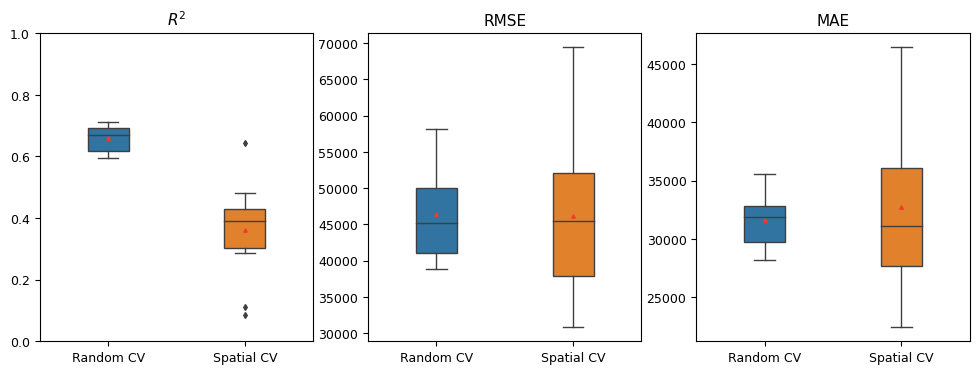

In [ ]:
fig, ax =  plt.subplots(1, 3, figsize=(12, 4))

my_colors = {'Random CV': '#1f77b4', 'Spatial CV': '#ff7f0e', 'C': 'gold'}

sns.boxplot(data = cv_metrics,
            hue = 'cv_type', 
            x = 'cv_type',
            y = 'r2',  
            dodge=False, width = .3, linewidth = 1, ax = ax[0],
            #palette= 'coolwarm',
            palette = my_colors,
            showmeans=True, meanprops={"markersize": "2.5", "markerfacecolor" : "#ef3b2c",
                    "markeredgecolor" : "#ef3b2c"} ,flierprops=dict(markersize=3))

ax[0].set_title( r'$R^2$',fontsize=11)
ax[0].set_ylabel('')
ax[0].set_xlabel('')
ax[0].set_ylim(0, 1)
ax[0].tick_params(labelsize = 9)
ax[0].legend([],[], frameon=False)

#
sns.boxplot(data = cv_metrics,
            hue = 'cv_type', 
            x = 'cv_type',
            y = 'rmse',  
            dodge=False, width = .3, linewidth = 1, ax = ax[1],
            #palette= 'coolwarm',
            palette = my_colors,
           showmeans=True, meanprops={"markersize": "2.5",  "markerfacecolor" : "#ef3b2c",
                    "markeredgecolor" : "#ef3b2c"},  flierprops=dict(markersize=3))
ax[1].set_title('RMSE',fontsize=11)
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].tick_params(labelsize = 9)
ax[1].legend([],[], frameon=False)

sns.boxplot(data = cv_metrics,
            hue = 'cv_type',
            x = 'cv_type',
            y = 'mae',  
            dodge=False, width = .3, linewidth = 1, ax = ax[2],
            #palette= 'coolwarm',
            palette = my_colors,
           showmeans=True, meanprops={"markersize": "2.5",  "markerfacecolor" : "#ef3b2c",
                    "markeredgecolor" : "#ef3b2c"},  flierprops=dict(markersize=3))
ax[2].set_title('MAE',fontsize=11)
ax[2].set_ylabel('')
ax[2].set_xlabel('')
ax[2].tick_params(labelsize = 9)

plt.legend([],[], frameon=False)
plt.show()